In [102]:
# Based on the PAD API database query notebook from Chris Sweet

# Imports
import dotenv, os
import pandas as pd

# Set env var OPENAI_API_KEY or load from a .env file:
dotenv.load_dotenv()
API_KEY=os.getenv('API_KEY') # you need to ask Chris nicely for an API key

# set url for pad server
PAD_URL = os.getenv('PAD_URL')

In [2]:
import grequests
import requests
from ipywidgets import interact

# Global to hold frame
df = None
jdata2 = None
r2 = None
projects = ['None']
project_ids = {'None':0}

# get cards by project
def get_cards_by_project(project):
  global df
  ret = None
  if int(project_ids[project]) > 0:
    # get cards by project
    print("loading project...")
    try:
      # sending get request and saving the response as response object
      APIURL2 = "https://pad.crc.nd.edu/api/v2/projects/{}/cards".format(project_ids[project])
      r2 = requests.get(url = APIURL2)

      # extracting data in json format
      jdata2 = r2.json()
      df = pd.DataFrame(jdata2)
      ret = f"Data loaded. Project [{project_ids[project]}]-{project} has {len(df)} cards."

    except Exception as e:
        print("API query error", e)

  return ret

# get projects

def get_projects():
  global jdata
  # get projects  - this is a one time call
  
  try:
    # sending get request and saving the response as response object
    APIURL1 = "https://pad.crc.nd.edu/api/v2/projects"
    r = requests.get(url = APIURL1)

    # extracting data in json format
    jdata = r.json()

  except Exception as e:
      print("API query error", e)

def pick_project():
  global projects
  global project_ids
  global jdata
  
  # get projects
  get_projects()
  
  # Create dropdown
  projects = ['None']
  project_ids = {'None':0}

  for i in range(0, len(jdata)):
    projects.append(jdata[i]['project_name'])
    project_ids[jdata[i]['project_name']] = jdata[i]['id']

  # widget function - do interaction to find project id and get data
  interact (get_cards_by_project, project=projects);

pick_project()


interactive(children=(Dropdown(description='project', options=('None', '2015-2016 USAID DIV project', '2016 PA…

In [3]:
## Functions
 
# Filter by sample_name column
def filter_by_sample_name(df, sample_name):
    return df[df['sample_name'].str.contains(sample_name, case=False)].copy()

# Filter by not empty and not null column_name
def filter_by_not_empty_column(df, column_name):
    if column_name not in df.columns:
        raise ValueError("The column name is not in the dataframe")
    else:
        return df[df[column_name].notnull() & (df[column_name] != "")].copy()
    
# Filter by 'unknown' column_name
def filter_by_unknown_column(df, column_name):
    if column_name not in df.columns:
        raise ValueError("The column name is not in the dataframe")
    else:
        return df[df[column_name] == "unknown"].copy()
    
# Filter by column_name and value
def filter_by_value_column(df, column_name, value):
    if column_name not in df.columns:
        raise ValueError(f"The column name {column_name} is not in the dataframe")
    else:
        return df[df[column_name] == value].copy()    

# Filter by column_name and value
def filter_by_no_value_column(df, column_name, value):
    if column_name not in df.columns:
        raise ValueError(f"The column name {column_name} is not in the dataframe")
    else:
        return df[df[column_name] != value].copy()    


def url_pad(file_location):
  return PAD_URL + str(file_location)


In [4]:
# Show issues
print("Deleted:")
print(df['deleted'].value_counts())

# Filter by issue
num_cards = len(df.index)
df = df[~df['deleted']]
print(f"\nFiltered {num_cards} cards to {len(df.index)} cards")

Deleted:
False    9489
True      214
Name: deleted, dtype: int64

Filtered 9703 cards to 9489 cards


In [5]:
# Add url to dataframe
df['url'] = df['processed_file_location'].apply(lambda x: f"https://pad.crc.nd.edu/{x}")

In [6]:
# Standardize the names of the samples
def standardize_names(name):
    return name.lower().replace(' ', '-')

df['sample_name'] = df['sample_name'].apply(standardize_names)
print(df.value_counts(['sample_name']).reset_index(name='counts'))

                   sample_name  counts
0           hydroxychloroquine     836
1                    isoniazid     532
2                 tetracycline     529
3                   rifampicin     500
4                ciprofloxacin     498
5             sulfamethoxazole     486
6                  ceftriaxone     480
7              ferrous-sulfate     465
8                 pyrazinamide     459
9                 azithromycin     446
10           benzyl-penicillin     446
11                 chloroquine     443
12                  ethambutol     440
13                        ripe     438
14                 epinephrine     416
15  promethazine-hydrochloride     411
16                 amoxicillin     394
17                 albendazole     332
18                  ampicillin     251
19                 doxycycline     247
20              starch-(maize)     133
21           calcium-carbonate     118
22               ascorbic-acid      83
23                     lactose      76
24                     un

##  select cards that have no issues

In [7]:


# selct only cards with issues
issue_samples = df[df['issue'].notnull()].copy()

# selct cards that have no issues
no_issue_samples = df[df['issue'].isnull()].copy()

print(f"Total num of samples: {len(df.index)} cards")
print(f"Total num of samples with no issues: {len(no_issue_samples.index)} cards")
print(f"Total num of samples with issues: {len(issue_samples.index)} cards")
print("\nSamples by issue:")
print(issue_samples['issue'].value_counts())

Total num of samples: 9489 cards
Total num of samples with no issues: 8309 cards
Total num of samples with issues: 1180 cards

Samples by issue:
{'id': 2, 'name': 'Leak', 'description': ''}             685
{'id': 3, 'name': 'Stuck', 'description': ''}            493
{'id': 4, 'name': 'Rectification', 'description': ''}      2
Name: issue, dtype: int64


## Find and Remove samples with `sample_name`==`unknown`

In [8]:
column_name = "sample_name"

print(f"Total samples: {len(no_issue_samples.index)}")

not_empty_sample_name = filter_by_not_empty_column(no_issue_samples, column_name)
print(f"Total num of samples with empty {column_name}: " +
      f"{len(no_issue_samples.index) - len(not_empty_sample_name.index)} samples")

unknown_sample_name = filter_by_unknown_column(no_issue_samples, column_name)
print(f"Total num of samples with unknown sample_name: {len(unknown_sample_name.index)} samples")

Total samples: 8309
Total num of samples with empty sample_name: 0 samples
Total num of samples with unknown sample_name: 30 samples


In [10]:
import ipyplot # https://github.com/karolzak/ipyplot/blob/master/notebooks/gear-images-examples.ipynb

label_column = 'sample_id'
images = unknown_sample_name['url'].values
labels = unknown_sample_name[label_column].values
labels_list_filtered = unknown_sample_name[label_column].unique().tolist()

# Show with tabs
ipyplot.plot_class_tabs(
    images, labels, tabs_order=labels_list_filtered, show_url=False,
)

# Show all
# ipyplot.plot_images(images, labels, show_url=False) # max_images=30, img_width=150)

In [16]:
filtered_df = no_issue_samples.copy()
filtered_df.shape

(8309, 16)

In [ ]:
unknown_sample_name[['id','sample_id','sample_name','quantity','test_name','user_name','date_of_creation','url']
                    ].to_csv('./data/FHI2020_analysis/check_samples_with_unknown_sample_name.csv', index=False)

In [18]:
# create a Boolean mask for the rows to remove
mask = filtered_df['id'].isin(unknown_sample_name["id"].values)

# select all rows except the ones that contain `unknown`
filtered_df = filtered_df[~mask]

filtered_df.shape

(8279, 16)

## `processed_file_location`

- Checking if there are any missing and unknow values in the `processed_file_location` column


In [23]:
column_name = "processed_file_location"
not_empty_proc_flocation = filter_by_not_empty_column(filtered_df, column_name)
print(f"Total num of samples with empty '{column_name}': " + 
      f"{len(filtered_df.index) - len(not_empty_proc_flocation.index)} samples")

unknown_proc_flocation = filter_by_unknown_column(filtered_df, column_name)
print(f"Total num of samples with unknown '{column_name}': {len(unknown_proc_flocation.index)} samples")

Total num of samples with empty 'processed_file_location': 0 samples
Total num of samples with unknown 'processed_file_location': 0 samples


## Download images

In [24]:
#import smallutils as su
import os
from functools import partial
import numpy as np


# Change the image name pattern in this function
def create_filename(x):
    """
    Create a standardized filename based on input data.

    Args:
        x (dict): A dictionary containing information to construct the filename.

    Returns:
        str: The constructed filename in the format "{id}__{sample_name}__{quantity}".

    Example:
        input_data = {
            'id': 123,
            'sample_name': 'Acetaminphen Codeine',
            'quantity': 5
        }
        filename = create_filename(input_data)
        # Resulting filename: "123__acetaminphen-codeine__5"
    """    
    # Convert `sample_name` to lowercase and replace spaces with hyphens
    transformed_name = x['sample_name'].lower().replace(' ', '-')
    
    # Create the filename
    #fname = f"{x['id']}__{transformed_name}__{x['quantity']}__{x['image_hash']}.png"
    fname = f"{x['id']}__{x['sample_id']}__{transformed_name}__{x['quantity']}.png"
    
    return fname

USER_AGENT = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36'
headers = { 'User-Agent': USER_AGENT }


def dl_images_fr_padserver(dff, tgt_folder, job_size = 100):
    """
        Download all images from the PAD server.
        Args:
            df: dataframe with the url column.
            tgt_folder: dir at which the image is stored.
            job_size: (int) number of downloads to spawn.
 
    """

    
    def _dl_file(r, folder_dir, filename, *args, **kwargs):
        fname = os.path.join(folder_dir, filename)
        
        if r.status_code == 200:
            with open(fname, 'wb') as my_file:
                # Read by 4KB chunks
                for byte_chunk in r.iter_content(chunk_size=1024*10):
                    if byte_chunk:
                        my_file.write(byte_chunk)
                        my_file.flush()
                        os.fsync(my_file)
        r.close()

 
    do_stuff = []
    #su.create_folder(tgt_folder)
    
    for _, sample in dff.iterrows():

        #handling grequest
        action_item = grequests.get(sample.url,
                                    hooks = {'response': partial(_dl_file,
                                                                folder_dir = tgt_folder,
                                                                filename = create_filename(sample))
                                             },
                                    headers = headers,
                                    stream = True)
        do_stuff.append(action_item)
 
    return grequests.map(do_stuff, size=job_size)

tgt_folder = './data/FHI2020_analysis/images_from_PADserver/'

ret_grequests = dl_images_fr_padserver(filtered_df, tgt_folder, job_size = 100)

In [27]:
# filtered_df["url_status_code"] = [r.status_code for r in ret_grequests] 
no_issue_samples = False

- Save the status code for the url requests in a new column called `url_status_code` 

In [31]:
url_status_code = []
for i, r in enumerate(ret_grequests):
    if r is None:
        url_status_code.append(200)
    else:
        url_status_code.append(r.status_code)

In [37]:
filtered_df["url_status_code"] = url_status_code

- Summary of the status code for the url requests

In [38]:
num_samples_with_processed_file = len(filtered_df[filtered_df['url_status_code']==200].index)
print(f"Total num of samples with image: {num_samples_with_processed_file} samples")

num_samples_without_processed_file = len(filtered_df[filtered_df['url_status_code']!=200].index)
print(f"Total num of samples with no image: {num_samples_without_processed_file} samples")

Total num of samples with image: 8279 samples
Total num of samples with no image: 0 samples


- Save the samples that have a status code different from 200 in a new csv file called `check_samples_without_processed_file.csv`

In [ ]:
filtered_df[['id','sample_id','sample_name','url']][filtered_df['url_status_code'] != 200].to_csv('./data/FHI2020_analysis/check_samples_without_processed_file.csv', index=False)

- Save the samples that have a status code equal 200 in a new csv file called `check_samples_with_processed_file.csv`

In [ ]:
filtered_df[['id','sample_id','sample_name','url']][filtered_df['url_status_code'] == 200].to_csv('./data/FHI2020_analysis/check_samples_with_processed_file.csv', index=False)

## `Hash`

In [28]:
import hashlib
import concurrent.futures
import os
        
def check_hash(sample, output_folder):
    filename = create_filename(sample)
    filepath = os.path.join(output_folder, filename)
    if os.path.exists(filepath):
        if sample['image_hash'] == hashlib.md5(open(filepath,'rb').read()).hexdigest():
            return True
        else:
            return False
    else:
        return False
    
def get_hash(sample, folder):
    filename = create_filename(sample)
    filepath = os.path.join(folder, filename)
    #print(sample['id'], sample['url_status_code'], filepath)
    if sample['url_status_code'] == 200:
        if os.path.isfile(filepath):
            hashlib_md5 = hashlib.md5(open(filepath,'rb').read()).hexdigest()
            #print(hashlib_md5)
            return hashlib_md5
        else:
            print(f"File not found {filepath}. Downloading...")
            status_code = save_image_from_url(sample, tgt_folder)
            if status_code == 200:
                hashlib_md5 = hashlib.md5(open(filepath,'rb').read()).hexdigest()
                return hashlib_md5
            else:
                print(f"Error downloading {sample['id']}. File not found {filepath}")
                return None
    else:        
        return None

def get_hash_all(df, folder):
    hash_codes = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_to_url = {
            executor.submit(get_hash, sample, folder): sample for _, sample in df.iterrows()
        }
        for future in concurrent.futures.as_completed(
            future_to_url
        ):
            sample = future_to_url[future]
            try:               
                #print(sample['id'], sample['url'], sample['url_status_code'] ,future.result())
                hash_codes.append([sample['id'], sample['url_status_code'], future.result()])
                
            except Exception as exc:
                print(
                    "%r generated an exception: %s" % (sample, exc)
                )
    return hash_codes

def save_image_from_url(sample, output_folder):
    r = requests.get(sample.url)
    output_path = os.path.join(
        output_folder, create_filename(sample)
    )
    with open(output_path, "wb") as f:
        f.write(r.content)
        
    status_code = r.status_code
    r.close()
    return status_code


def delete_image(sample, folder):
    filename = create_filename(sample)
    filepath = os.path.join(folder, filename)
    print(filepath)
    if os.path.exists(filepath):
        os.remove(filepath)
        


- Calculating the hash of the processed files

In [41]:
hash_codes = get_hash_all(filtered_df, tgt_folder)


- Checking if there are any missing values in the `hash` results for url_status_code == 200

In [42]:
ids_to_download = [id for id, url_status_code, hash_code in hash_codes if hash_code == None and url_status_code == 200]
len(ids_to_download)

0

- In case, for some reason(?), there are samples that have url_status_code equal to 200 but they weren't downloaded, you can try to download images that have url_status_code equal to 200 and hash equal to None again.

In [ ]:
# filter rows based on list values
dl_images_fr_padserver(filtered_df[filtered_df['id'].isin(ids_to_download)], tgt_folder, job_size = 100)

# Then, you can calculate the hash of the images again and see if I can find the images that have hash equal to None.
hash_codes = get_hash_all(filtered_df, tgt_folder)

## Finally, you can create a new column called `hashlib_md5` with the hash of the images

In [43]:
hash_codes_df = pd.DataFrame(hash_codes, columns=['id', 'url_status_code', 'hashlib_md5'])
hash_codes_df.drop(columns=['url_status_code'], inplace=True)
filtered_df = filtered_df.merge(hash_codes_df, on='id')

### `Check if there are any samples that have the same hash`

In [44]:
filtered_df['url_status_code'].value_counts()

200    8279
Name: url_status_code, dtype: int64

In [45]:
num_samples = filtered_df['url_status_code'].isin([200]).sum()
data = filtered_df.groupby(['hashlib_md5']).size().reset_index(name='counts')
one_sample_hash = data[data['counts']==1]
two_more_sample_hash = data[data['counts']>1]

print('Summary:')
print(f"Total unique hash codes : {len(data.index)}")
print(f"Total of hash code with one sample: {len(one_sample_hash.index)}")
print(f"Total of hash code with two or more samples: {len(two_more_sample_hash.index)}")

print('')
print(f"Total of samples: {num_samples}")
print(f"Total of samples without duplicates: {len(data.index)}")
print(f"Total of samples in some duplicate case (will be deleted): {num_samples-len(data.index)}")

Summary:
Total unique hash codes : 7888
Total of hash code with one sample: 7600
Total of hash code with two or more samples: 288

Total of samples: 8279
Total of samples without duplicates: 7888
Total of samples in some duplicate case (will be deleted): 391


- Handling the samples that have the same hash
    
    - There are two cases of duplicates: 
        - [A] Samples that have the same hash and the same value in the columns `['sample_id','sample_name', 'camera_type_1' and 'quantity']`
        - [B] Samples that have the same hash but any different values in one or more columns `['sample_id','sample_name', 'camera_type_1' and 'quantity']`

In [46]:
list_dup_hash = two_more_sample_hash['hashlib_md5'].to_list()
type_A = []
type_B = []

for hash in list_dup_hash:
    print(f"Hash code: {hash}")
    data = filtered_df[filtered_df['hashlib_md5']==hash].copy()
    print(f"Total of samples before: {len(data.index)}")
    unique_samples = data.drop_duplicates(subset=['sample_id','sample_name','camera_type_1', 'quantity'], keep=False)
    print(f"Total of samples after: {len(unique_samples.index)}")
    if  len(unique_samples.index) == 0:
        # A
        print(f"A: real duplicates: {len(data.index)}")
        type_A.append(hash)
    else:
        print(f"B: Samples with issue {len(data.index)}")    
        # B
        type_B.append(hash)
    print('')

Hash code: 03a29e3fbec78a36d8702782808c437a
Total of samples before: 3
Total of samples after: 0
A: real duplicates: 3

Hash code: 03c0db723d94938e8a9ae7537c897592
Total of samples before: 2
Total of samples after: 0
A: real duplicates: 2

Hash code: 03feeb5f7fe8cde65f1bc675fbacd0e2
Total of samples before: 2
Total of samples after: 0
A: real duplicates: 2

Hash code: 041faa9a3603b9ebe5e6a3182a46fcb9
Total of samples before: 3
Total of samples after: 0
A: real duplicates: 3

Hash code: 04b768ce938cfc8849df01df582bbe14
Total of samples before: 2
Total of samples after: 2
B: Samples with issue 2

Hash code: 04cb4e5ed1500896f7f075c43d226361
Total of samples before: 4
Total of samples after: 0
A: real duplicates: 4

Hash code: 0679bab4f414a40b8550d203c2edb85c
Total of samples before: 2
Total of samples after: 0
A: real duplicates: 2

Hash code: 08831ac317c9d3462ccacc61d8f53c9c
Total of samples before: 2
Total of samples after: 0
A: real duplicates: 2

Hash code: 08da418530588070b12bdad5b70

In [47]:
print('Summary:')
print(f"Type A: Total hash codes with real duplicate cases: {len(type_A)}")
print(f"Type B: Total hash codes with not real duplicate cases: {len(type_B)}")

Summary:
Type A: Total hash codes with real duplicate cases: 255
Type B: Total hash codes with not real duplicate cases: 33


- **[A] Visualize Samples that have the same hash and the same value in the columns `['sample_id','sample_name', 'camera_type_1' and 'quantity']`**

In [48]:
import ipyplot 
sub_list = type_A[0:6]
data = filtered_df[filtered_df['hashlib_md5'].isin(sub_list)].copy()
label_column = 'hashlib_md5'
images = data['url'].values
labels = data[label_column].values
labels_list_filtered = data[label_column].unique().tolist()

# Show with tabs
ipyplot.plot_class_tabs(
    images, labels, tabs_order=labels_list_filtered, show_url=False,
)

In [49]:
for hash in sub_list:
    print(f"Hash: {hash}")
    print(data[data['hashlib_md5'] == hash][['id', 'sample_id','sample_name','url', 'camera_type_1', 'quantity']].to_string(index=False))

Hash: 03a29e3fbec78a36d8702782808c437a
   id  sample_id  sample_name                                                                                       url   camera_type_1  quantity
18676      52051 tetracycline https://pad.crc.nd.edu//var/www/html/images/padimages/processed/10000/18676_processed.png Google Pixel 3a        20
18680      52051 tetracycline https://pad.crc.nd.edu//var/www/html/images/padimages/processed/10000/18680_processed.png Google Pixel 3a        20
18689      52051 tetracycline https://pad.crc.nd.edu//var/www/html/images/padimages/processed/10000/18689_processed.png Google Pixel 3a        20
Hash: 03c0db723d94938e8a9ae7537c897592
   id  sample_id sample_name                                                                                       url    camera_type_1  quantity
23795      52985  rifampicin https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23795_processed.png samsung SM-A505F        50
23830      52985  rifampicin https://pad.crc.n

In [50]:
print(f"[Type B] Total of hash codes: {len(type_B)}")

[Type B] Total of hash codes: 33


In [51]:
sub_list = type_B[0:6]
data = filtered_df[filtered_df['hashlib_md5'].isin(sub_list)].copy()
label_column = 'hashlib_md5'
images = data['url'].values
labels = data[label_column].values
labels_list_filtered = data[label_column].unique().tolist()

# Show with tabs
ipyplot.plot_class_tabs(
    images, labels, tabs_order=labels_list_filtered, show_url=False,
)


In [52]:
# save to csv
type_B_duplicates_samples = filtered_df[filtered_df['hashlib_md5'].isin(type_B)].copy().sort_values(by='hashlib_md5')
type_B_duplicates_samples[['hashlib_md5', 'id','sample_id', 'camera_type_1', 'quantity', 'url' ]].to_csv('./data/FHI2020_analysis/check_type_B_duplicates_samples.csv', index=False)


In [53]:
for hash in type_B:
    
    print(f"Hash: {hash}")
    print(filtered_df[filtered_df['hashlib_md5'] == hash][['id','sample_id','sample_name','url', 'camera_type_1', 'quantity']].to_string(index=False),'\n')

Hash: 04b768ce938cfc8849df01df582bbe14
   id  sample_id  sample_name                                                                                       url        camera_type_1  quantity
24526      55092 azithromycin https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/24526_processed.png HMD Global Nokia 2.3       100
24775      55332 azithromycin https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/24775_processed.png HMD Global Nokia 2.3        20 

Hash: 13444e3cb26bf97be40e39169253e14c
   id  sample_id     sample_name                                                                                       url        camera_type_1  quantity
23049      52979 ferrous-sulfate https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23049_processed.png HMD Global Nokia 2.3       100
23380      52827 ferrous-sulfate https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23380_processed.png     samsung SM-A505F        50 

Has

## Exclude duplicates for type B from a checked spreadsheet 

In [105]:
checked_type_B = pd.read_csv('./data/FHI2020_analysis/checked_type_B_duplicates_samples.csv')
ids = checked_type_B['id'][(checked_type_B['exclude']==True) & (~checked_type_B['id'].isnull())].astype('int64').values
mask = filtered_df['id'].isin(ids)

for _, sample in filtered_df[(mask)].iterrows():
    delete_image(sample, tgt_folder)

# keep only data from not exclude ids list by mask
data = filtered_df[(~mask)]

./data/FHI2020_analysis/images_from_PADserver/18437__52112__tetracycline__100.png
./data/FHI2020_analysis/images_from_PADserver/18536__51996__tetracycline__50.png
./data/FHI2020_analysis/images_from_PADserver/19352__52648__ceftriaxone__50.png
./data/FHI2020_analysis/images_from_PADserver/19353__52031__ceftriaxone__100.png
./data/FHI2020_analysis/images_from_PADserver/19456__52664__ceftriaxone__50.png
./data/FHI2020_analysis/images_from_PADserver/19614__52661__ceftriaxone__20.png
./data/FHI2020_analysis/images_from_PADserver/19714__52645__sulfamethoxazole__50.png
./data/FHI2020_analysis/images_from_PADserver/19806__52205__sulfamethoxazole__80.png
./data/FHI2020_analysis/images_from_PADserver/22665__52764__ethambutol__20.png
./data/FHI2020_analysis/images_from_PADserver/22849__52903__ethambutol__80.png
./data/FHI2020_analysis/images_from_PADserver/23038__51804__ferrous-sulfate__100.png
./data/FHI2020_analysis/images_from_PADserver/23049__52979__ferrous-sulfate__100.png
./data/FHI2020_ana

## Exclude duplicates for type A from a checked spreadsheet 

In [80]:
# save  filtered_df dataframe to csv
#data.to_csv('./data/FHI2020_analysis/filtered_df.csv', index=False)

In [2]:
import pandas as pd
# load no_issue_samples dataframe from csv
data = pd.read_csv('./data/FHI2020_analysis/filtered_df.csv')

In [15]:

num_samples = data['url_status_code'].isin([200]).sum()
print("num_samples ", num_samples)

data_grp = data.groupby(['hashlib_md5']).size().reset_index(name='counts')


one_sample_hash = data_grp[data_grp['counts']==1]
two_more_sample_hash = data_grp[data_grp['counts']>1]


print('Summary:')
print(f"Total unique hash codes : {len(data.index)}")
print(f"Total of hash code with one sample: {len(one_sample_hash.index)}")
print(f"Total of hash code with two or more samples: {len(two_more_sample_hash.index)}")

print('')
print(f"Total of samples: {num_samples}")
print(f"Total of samples without duplicates: {len(data_grp.index)}")
print(f"Total of samples in some duplicate case (will be deleted): {num_samples-len(data_grp.index)}")


num_samples  8245
Summary:
Total unique hash codes : 8245
Total of hash code with one sample: 7633
Total of hash code with two or more samples: 255

Total of samples: 8245
Total of samples without duplicates: 7888
Total of samples in some duplicate case (will be deleted): 357


In [16]:

list_dup_hash = two_more_sample_hash['hashlib_md5'].to_list()
type_A = []
type_B = []

for hash in list_dup_hash:
    print(f"Hash code: {hash}")
    data_grp = data[data['hashlib_md5']==hash].copy()
    print(f"Total of samples before: {len(data.index)}")
    unique_samples = data_grp.drop_duplicates(subset=['sample_id','sample_name','camera_type_1', 'quantity'], keep=False)
    print(f"Total of samples after: {len(unique_samples.index)}")
    if  len(unique_samples.index) == 0:
        # A
        print(f"A: real duplicates: {len(data_grp.index)}")
        type_A.append(hash)
    else:
        print(f"B: Samples with issue {len(data_grp.index)}")    
        # B
        type_B.append(hash)
    print('')



Hash code: 03a29e3fbec78a36d8702782808c437a
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 3

Hash code: 03c0db723d94938e8a9ae7537c897592
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 2

Hash code: 03feeb5f7fe8cde65f1bc675fbacd0e2
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 2

Hash code: 041faa9a3603b9ebe5e6a3182a46fcb9
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 3

Hash code: 04cb4e5ed1500896f7f075c43d226361
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 4

Hash code: 0679bab4f414a40b8550d203c2edb85c
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 2

Hash code: 08831ac317c9d3462ccacc61d8f53c9c
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 2

Hash code: 08da418530588070b12bdad5b7095670
Total of samples before: 8245
Total of samples after: 0
A: real duplicates: 4

Hash code: 09062

In [19]:
len(type_A), len(type_B) 

(255, 0)

In [20]:
id_list_to_exclude = []
for hash in type_A:
    #print(f"Hash code: {hash}")
    df_tmp = data[data['hashlib_md5']==hash].copy() 
    id_list_dup = df_tmp['id'].to_list()
    id_list_to_exclude += id_list_dup[1:]
    #print(id_list_dup[0],id_list_dup[1:], id_list_dup)

len(id_list_to_exclude)
    

357

In [31]:
# mask to exclude samples
mask = data['id'].isin(id_list_to_exclude)
excluded_samples = data[(mask)]

# delete image files correspondent to the ids in the mas 
for _, sample in excluded_samples.iterrows():
    delete_image(sample, tgt_folder)

# keep only data from not excluded ids (listed in the mask)
data = data[(~mask)]
data.shape

./data/FHI2020_analysis/images_from_PADserver/16038__53675__promethazine-hydrochloride__100.png
./data/FHI2020_analysis/images_from_PADserver/18315__52477__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/18316__52477__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/18317__52469__isoniazid__80.png
./data/FHI2020_analysis/images_from_PADserver/18318__52454__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/18319__52321__isoniazid__80.png
./data/FHI2020_analysis/images_from_PADserver/18321__52322__isoniazid__80.png
./data/FHI2020_analysis/images_from_PADserver/18322__52460__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/18324__52320__isoniazid__80.png
./data/FHI2020_analysis/images_from_PADserver/18325__52463__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/18326__52223__isoniazid__80.png
./data/FHI2020_analysis/images_from_PADserver/18327__52486__isoniazid__50.png
./data/FHI2020_analysis/images_from_PADserver/

(7888, 18)

### Single samples

Here, I am disregarding whether the same PAD was photographed several times.

In [124]:
samples_unique = data[['sample_id','sample_name']].value_counts().reset_index(name='counts')
print(f"Total of Unique samples {samples_unique.shape[0]}")

samples_unique_grp = samples_unique.groupby(['sample_name']).size().reset_index(name='counts')
samples_unique_grp.sort_values(by=['counts'], ascending=False)

Total of Unique samples 2244


,sample_name,counts
19,rifampicin,122
22,sulfamethoxazole,120
9,ciprofloxacin,117
10,doxycycline,115
8,chloroquine,113
15,isoniazid,112
4,azithromycin,112
13,ferrous-sulfate,112
18,pyrazinamide,111
1,amoxicillin,111


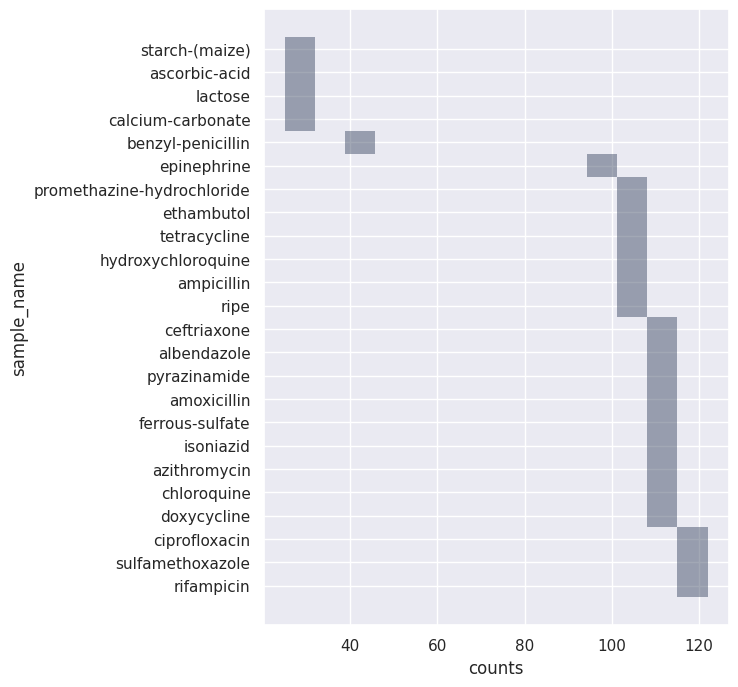

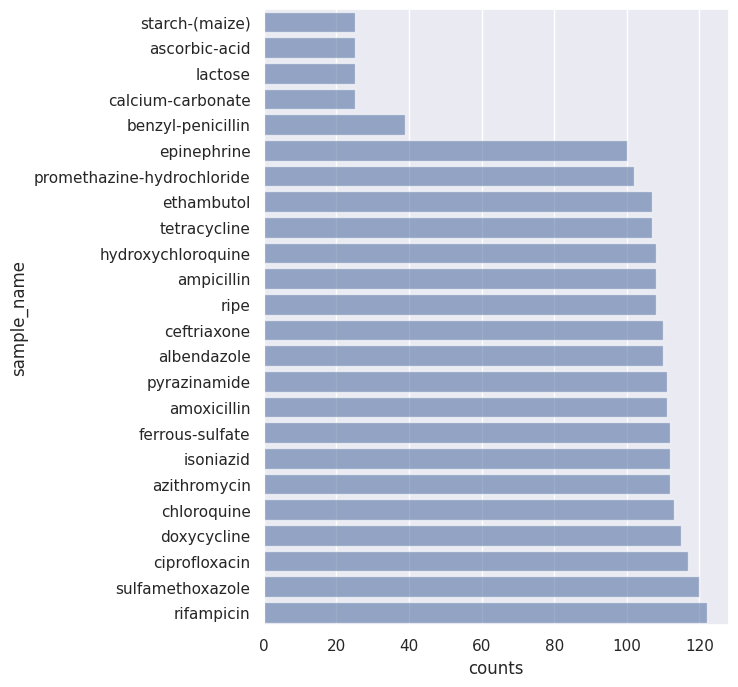

In [130]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(6, 8))
sns.histplot(data=samples_unique_grp.sort_values(by=['counts']), x="counts",  y="sample_name",  alpha=0.5, linewidths=.8)
plt.show()

fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(samples_unique_grp.sort_values(by=['counts']), x='counts', y="sample_name", orient="y", alpha=0.6)
plt.show()

In [134]:
samples_unique = data[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')


,sample_id,sample_name,quantity,counts
0,53000,hydroxychloroquine,20,27
1,51730,hydroxychloroquine,20,24
2,51727,hydroxychloroquine,20,22
3,53006,hydroxychloroquine,20,21
4,53004,hydroxychloroquine,20,18
...,...,...,...,...
2246,53476,ampicillin,100,1
2247,53475,ampicillin,80,1
2248,53472,ampicillin,80,1
2249,53430,albendazole,100,1


In [141]:
df2 = samples_unique[['sample_id','sample_name', 'counts']]
df1 = data[['sample_id','sample_name']].value_counts().reset_index(name='counts')

df1.shape, df2.shape, 2251 - 2244

((2244, 3), (2251, 3), 7)

In [150]:
diff_df = df1[~df1.apply(tuple,1).isin(df2.apply(tuple,1))]
diff_df

,sample_id,sample_name,counts
85,53816,chloroquine,6
98,53808,chloroquine,6
103,53817,chloroquine,6
168,52159,rifampicin,5
562,53818,chloroquine,4
1340,52280,rifampicin,4
2003,53835,chloroquine,2


In [ ]:
ids_error =  diff_df['sample_id'].to_list()

In [153]:
samples_unique[samples_unique['sample_id'].isin(ids_error)]

,sample_id,sample_name,quantity,counts
110,53808,chloroquine,20,5
124,53816,chloroquine,20,5
127,53817,chloroquine,20,5
1040,52159,rifampicin,80,4
1393,52280,rifampicin,80,3
1396,53818,chloroquine,20,3
2127,52159,rifampicin,100,1
2154,52280,rifampicin,100,1
2188,53835,chloroquine,100,1
2189,53835,chloroquine,80,1


In [154]:
df1[df1['sample_id'].isin(ids_error)]

,sample_id,sample_name,counts
85,53816,chloroquine,6
98,53808,chloroquine,6
103,53817,chloroquine,6
168,52159,rifampicin,5
562,53818,chloroquine,4
1340,52280,rifampicin,4
2003,53835,chloroquine,2


### Fixing quantities


In [166]:
def list_url_by_camera_type(df, sample_id):
    samples = df[df['sample_id'] == sample_id]
    print(f"Sample ID: {sample_id}")
    for _,sample in samples.iterrows():
        print(f"{sample['id']}\t{sample_id}\t{sample['sample_name']}\t{sample['camera_type_1']}\t\t{sample['quantity']}\t{sample['url']}")

for id in ids_error:
    list_url_by_camera_type(data, sample_id=id) 
    show_by_camera_type(data, sample_id=id)

Sample ID: 53816
20360	53816	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20360_processed.png
20376	53816	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20376_processed.png
20409	53816	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20409_processed.png
20426	53816	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20426_processed.png
20438	53816	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20438_processed.png
20503	53816	chloroquine	iPhone 11		50	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20503_processed.png


Sample ID: 53808
20313	53808	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20313_processed.png
20327	53808	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20327_processed.png
20354	53808	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20354_processed.png
20392	53808	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20392_processed.png
20414	53808	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20414_processed.png
20661	53808	chloroquine	Galaxy S9		50	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20661_processed.png


Sample ID: 53817
20321	53817	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20321_processed.png
20386	53817	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20386_processed.png
20393	53817	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20393_processed.png
20400	53817	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20400_processed.png
20403	53817	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20403_processed.png
20639	53817	chloroquine	Galaxy S9		50	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20639_processed.png


Sample ID: 52159
23661	52159	rifampicin	samsung SM-A505F		100	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23661_processed.png
23670	52159	rifampicin	HMD Global Nokia 2.3		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23670_processed.png
23920	52159	rifampicin	samsung SM-A505F		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23920_processed.png
23923	52159	rifampicin	samsung SM-A505F		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23923_processed.png
23933	52159	rifampicin	HMD Global Nokia 2.3		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23933_processed.png


Sample ID: 53818
20351	53818	chloroquine	Galaxy S9		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20351_processed.png
20396	53818	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20396_processed.png
20435	53818	chloroquine	iPhone 11		20	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20435_processed.png
20627	53818	chloroquine	Galaxy S9		50	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20627_processed.png


Sample ID: 52280
23657	52280	rifampicin	HMD Global Nokia 2.3		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23657_processed.png
23659	52280	rifampicin	samsung SM-A505F		100	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23659_processed.png
23678	52280	rifampicin	samsung SM-A505F		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23678_processed.png
23829	52280	rifampicin	HMD Global Nokia 2.3		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23829_processed.png


Sample ID: 53835
20465	53835	chloroquine	Galaxy S9		100	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20465_processed.png
20576	53835	chloroquine	Galaxy S9		80	https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20576_processed.png


In [110]:
samples_to_be_fixed=[[20503,	53816,	"chloroquine",	"iPhone 11",		50,	20,"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20503_processed.png"],
[20661,	53808,	"chloroquine",	"Galaxy S9",		50,	20,"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20661_processed.png"],
[20639,	53817,	"chloroquine",	"Galaxy S9",		50, 20,	"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20639_processed.png"],
[23661,	52159,	"rifampicin",	"samsung SM-A505F",		100, 80,	"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23661_processed.png"],
[20627,	53818,	"chloroquine",	"Galaxy S9",		50, 20,	"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20627_processed.png"],
[23659,	52280,	"rifampicin",	"samsung SM-A505F",		100, 80,	"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/23659_processed.png"],
[20576,	53835,	"chloroquine",	"Galaxy S9",		80, 100,	"https://pad.crc.nd.edu//var/www/html/images/padimages/processed/20000/20576_processed.png"]]

samples_to_be_fixed = pd.DataFrame(samples_to_be_fixed, columns=['id', 'sample_id', 'sample_name', 'camera_type_1', 'quantity', 'true_quantity', 'url'])
samples_to_be_fixed.to_csv('./data/FHI2020_analysis/samples_to_be_fixed.csv', index=False)

In [155]:
for _, sample in samples_to_be_fixed.iterrows():
    data.loc[data.id == sample.id, 'quantity'] = sample.true_quantity
    #print(sample.id, sample.true_quantity, data.loc[data.id == sample.id, 'quantity'].values[0]) 

In [112]:
# rename the files that were downloaded with incorrect name
 os.rename(tgt_folder + '20503__53816__chloroquine__50.png', tgt_folder + '20503__53816__chloroquine__20.png')

3711    20
Name: quantity, dtype: int64

In [ ]:
os.rename(tgt_folder + '20503__53816__chloroquine__50.png', tgt_folder + '20503__53816__chloroquine__20.png')
os.rename(tgt_folder + '20661__53808__chloroquine__50.png', tgt_folder + '20661__53808__chloroquine__20.png
os.rename(tgt_folder + '20639__53817__chloroquine__50.png', tgt_folder + '20639__53817__chloroquine__20.png')
os.rename(tgt_folder + '23661__52159__rifampicin__100.png', tgt_folder + '23661__52159__rifampicin__80.png')
os.rename(tgt_folder + '20627__53818__chloroquine__50.png', tgt_folder + '20627__53818__chloroquine__20.png')
os.rename(tgt_folder + '23659__52280__rifampicin__100.png', tgt_folder + '23659__52280__rifampicin__80.png')
os.rename(tgt_folder + '20576__53835__chloroquine__80.png', tgt_folder + '20576__53835__chloroquine__100.png')

In [164]:
!pwd

/afs/crc.nd.edu/user/p/pmoreira/pad_dataset_registry/nbs


## Cleaned Data

On that point the dataframe `data` should have the cleaned data samples to put in the dataset.


In [113]:
# save cleaned dataframe to csv
data.to_csv('./data/FHI2020_analysis/cleaned_data.csv', index=False)

## General Analysis

In [114]:
import pandas as pd
import sys
import ipyplot
sys.path.append("../src/")
from utils import *

In [115]:
# load no_issue_samples dataframe from csv
data = pd.read_csv('./data/FHI2020_analysis/cleaned_data.csv')

### Sample names

In [116]:
data['sample_name'] = data['sample_name'].apply(standardize_names)
print(data.value_counts(['sample_name']).reset_index(name='counts'))

                   sample_name  counts
0           hydroxychloroquine     821
1                   rifampicin     476
2                ciprofloxacin     455
3                 pyrazinamide     447
4                 azithromycin     438
5                  chloroquine     438
6              ferrous-sulfate     438
7                         ripe     427
8                   ethambutol     403
9                  ceftriaxone     387
10                 amoxicillin     386
11                tetracycline     382
12            sulfamethoxazole     368
13  promethazine-hydrochloride     351
14                 epinephrine     334
15                   isoniazid     327
16                 albendazole     281
17                 doxycycline     205
18                  ampicillin     186
19           benzyl-penicillin      94
20                     lactose      71
21              starch-(maize)      63
22           calcium-carbonate      60
23               ascorbic-acid      50


In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks",{'axes.grid' : True})
sns.set()
#diverging_colors = sns.color_palette("RdBu", 10)
#sns.palplot(diverging_colors)

drug_counter = data[['sample_name']].value_counts().reset_index(name='counts')
drug_quantity_counter = data[['sample_name', 'quantity']].value_counts().reset_index(name='counts')

drug_counter.sort_values(by='sample_name',  inplace=True)
drug_quantity_counter.sort_values(by=['sample_name', 'quantity'], inplace=True)
#drug_quantity_counter['sample_name'].unique().tolist() == drug_counter['sample_name'].to_list()

In [118]:
drug_counter.sort_values(by=['counts', 'sample_name'])

,sample_name,counts
23,ascorbic-acid,50
22,calcium-carbonate,60
21,starch-(maize),63
20,lactose,71
19,benzyl-penicillin,94
18,ampicillin,186
17,doxycycline,205
16,albendazole,281
15,isoniazid,327
14,epinephrine,334


<Axes: xlabel='counts', ylabel='sample_name'>

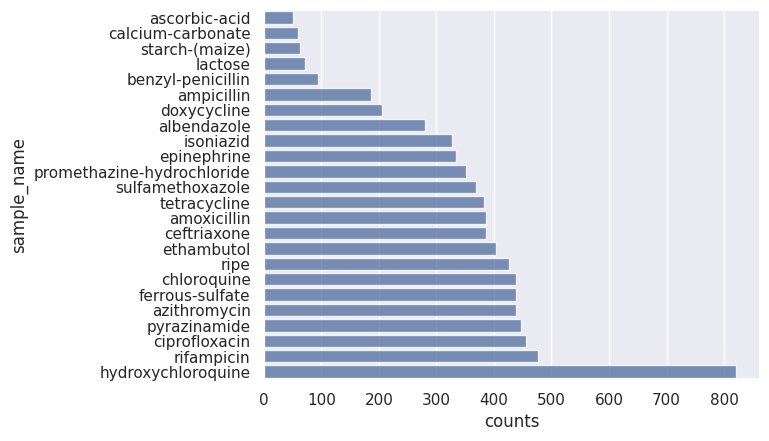

In [119]:
# Total of samples by drug
sns.barplot(drug_counter.sort_values(by=['counts']), x='counts', y="sample_name", orient="y", alpha=0.8)

<Axes: xlabel='counts', ylabel='sample_name'>

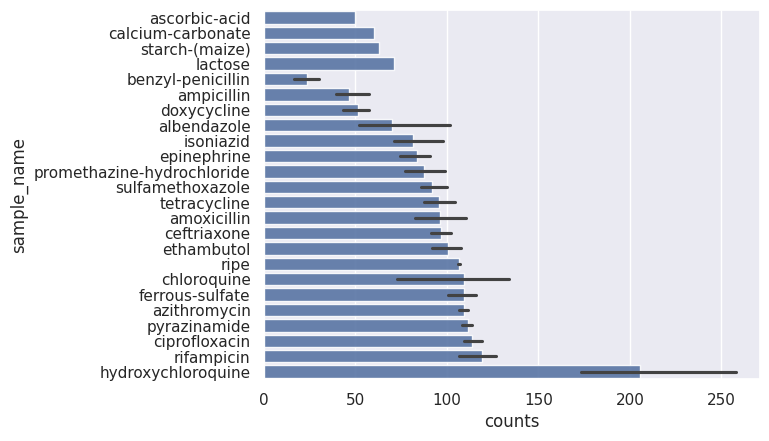

In [120]:
sample_name_list = drug_counter.sort_values(by=['counts'])['sample_name'].to_list()

drug_quantity_counter_cat = drug_quantity_counter.copy()
drug_quantity_counter_cat['sample_name'] = pd.Categorical(drug_quantity_counter['sample_name'], sample_name_list)

sns.barplot(drug_quantity_counter_cat, x='counts', y="sample_name", orient="y", alpha=0.9)

In [121]:
drug_quantity_counter[drug_quantity_counter['sample_name']=='benzyl-penicillin']

,sample_name,quantity,counts
81,benzyl-penicillin,20,29
83,benzyl-penicillin,50,12
80,benzyl-penicillin,80,31
82,benzyl-penicillin,100,22


<Axes: xlabel='quantity', ylabel='sample_name'>

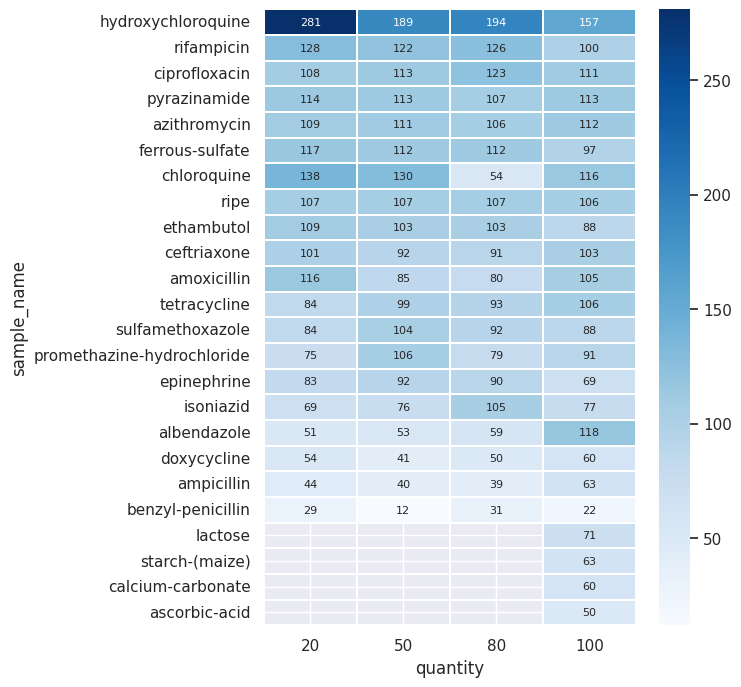

In [122]:
drug_quantity_counter_cat_rev = drug_quantity_counter_cat.copy()
drug_quantity_counter_cat_rev['sample_name'] = pd.Categorical(drug_quantity_counter['sample_name'], sample_name_list[::-1])

table = drug_quantity_counter_cat_rev.pivot(index="sample_name", columns="quantity", values="counts")
fig, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)


In [123]:
table.to_csv('./data/FHI2020_analysis/heatmap_drug_quantity_after_cleaning.csv')

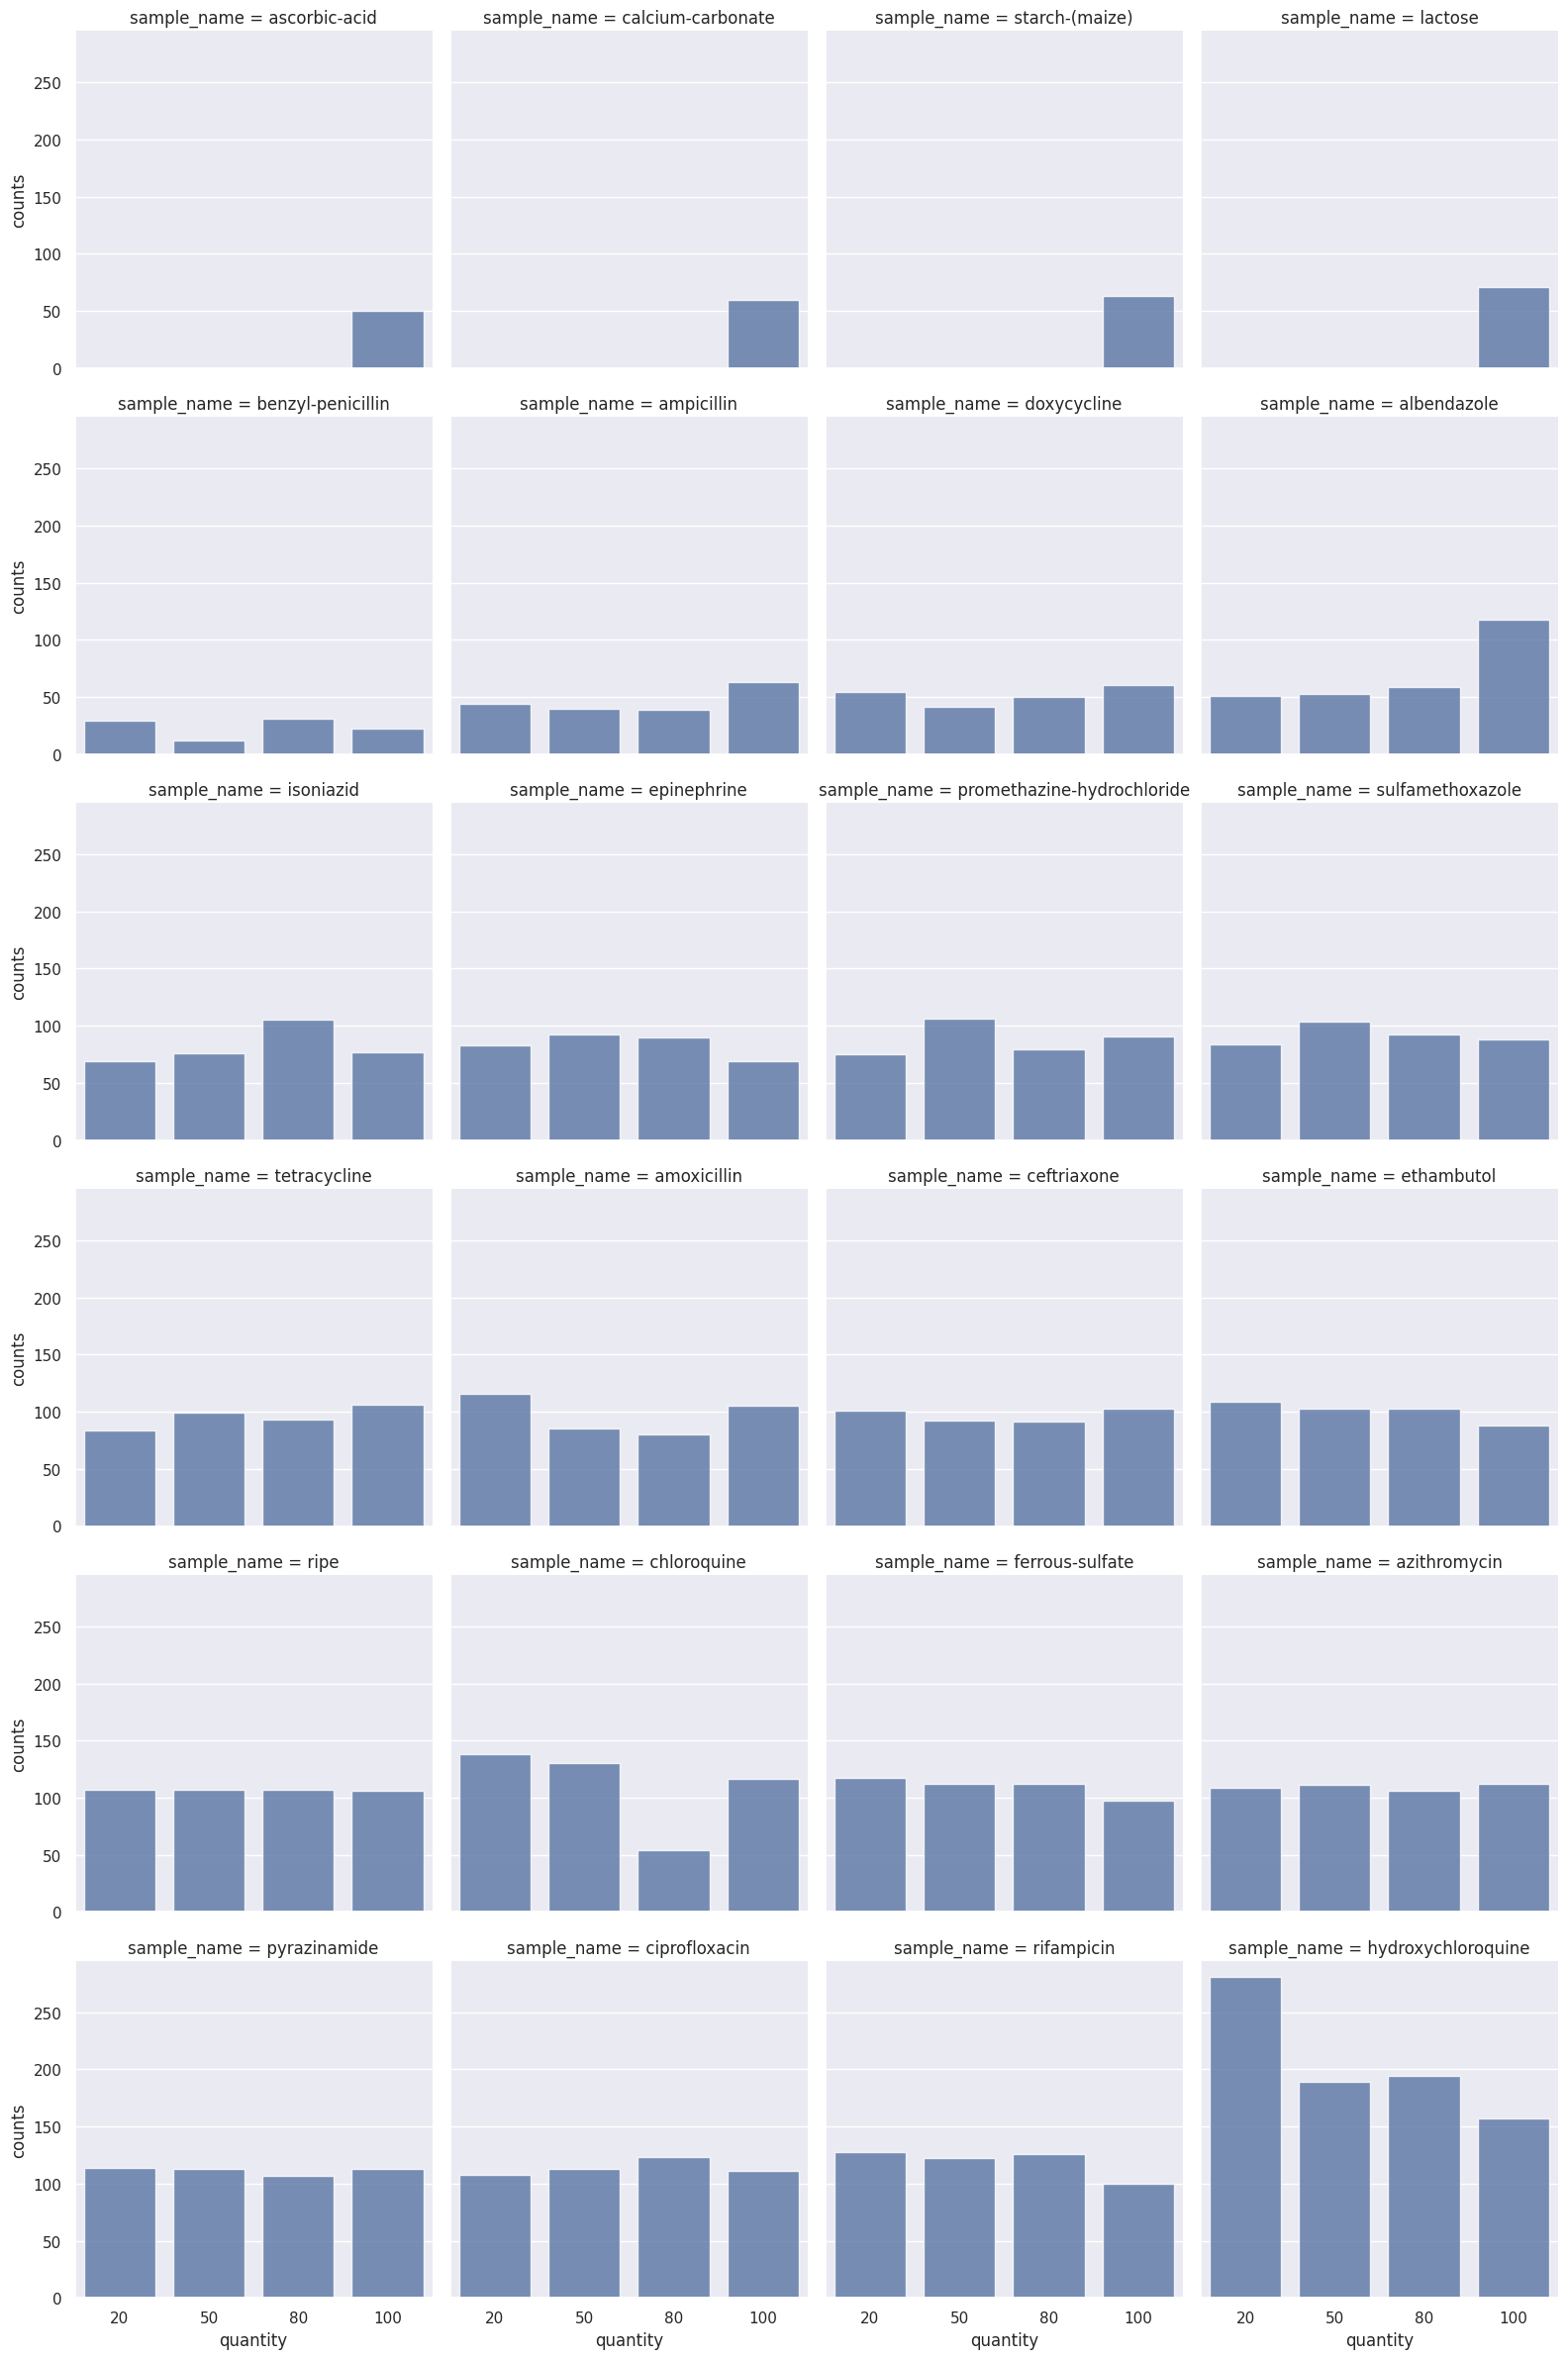

In [124]:
g = sns.FacetGrid(drug_quantity_counter_cat, col="sample_name", col_wrap=4, height=4)
g.map(sns.barplot, 'quantity', "counts",  order=[20,50,80,100], alpha=0.8)

#### camera_type_1

In [125]:
data[['sample_id','sample_name','quantity', 'camera_type_1']].value_counts().reset_index(name='counts')

,sample_id,sample_name,quantity,camera_type_1,counts
0,53000,hydroxychloroquine,20,Galaxy S9,23
1,51730,hydroxychloroquine,20,Galaxy S9,19
2,53006,hydroxychloroquine,20,Galaxy S9,18
3,51727,hydroxychloroquine,20,Galaxy S9,17
4,53004,hydroxychloroquine,20,Galaxy S9,13
...,...,...,...,...,...
4067,53430,albendazole,100,Google Pixel 3a,1
4068,53427,albendazole,100,Google Pixel 3a,1
4069,53426,albendazole,100,Jessica Galaxy,1
4070,53425,albendazole,100,Google Pixel 3a,1


In [126]:
camera_counter = data[['camera_type_1']].value_counts().reset_index(name='counts')
camera_counter

,camera_type_1,counts
0,samsung SM-A505F,3103
1,HMD Global Nokia 2.3,1803
2,Google Pixel 3a,1288
3,Galaxy S9,771
4,Heather Iphone XS,302
5,BLU BLU R1 HD,250
6,iPhone 11,201
7,Kat Galaxy S9,110
8,Jessica Galaxy,56
9,samsung SM-G770U1,4


<Axes: xlabel='counts', ylabel='camera_type_1'>

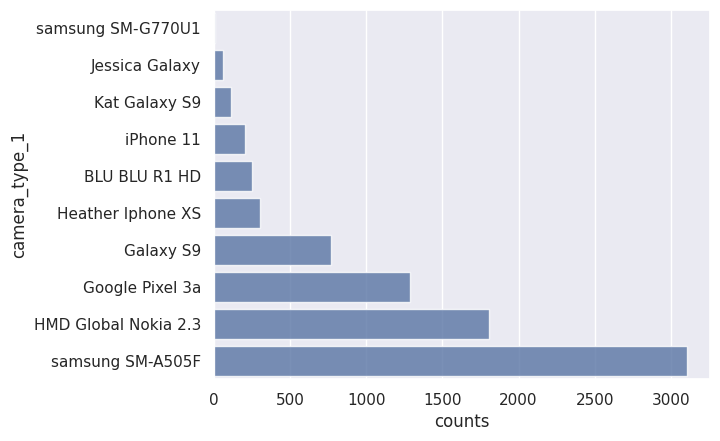

In [127]:
# Total of samples by drug
sns.barplot(camera_counter.sort_values(by=['counts']), x='counts', y="camera_type_1", orient="y", alpha=0.8)

<Axes: xlabel='sample_name', ylabel='camera_type_1'>

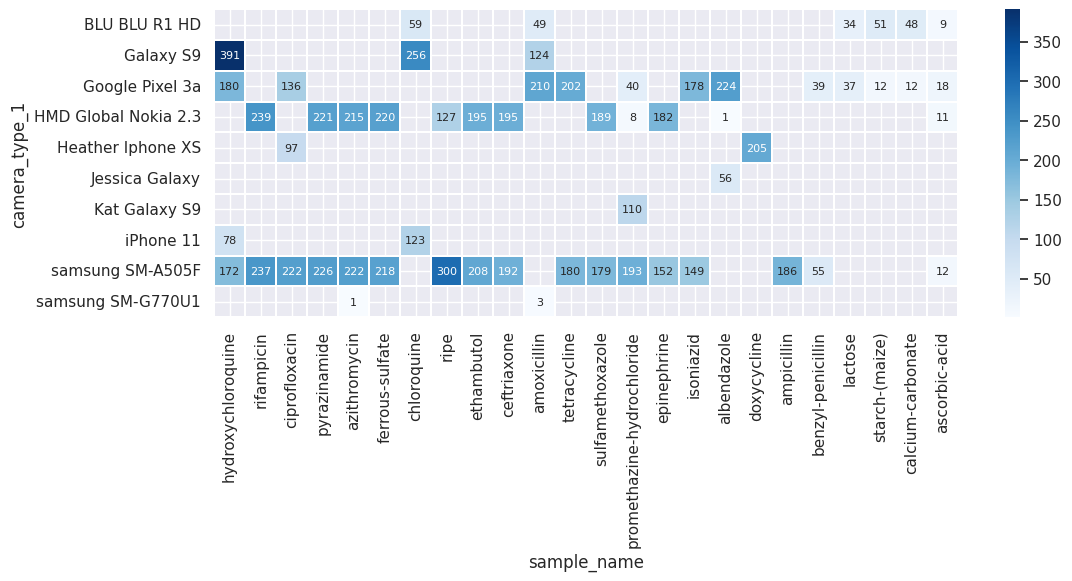

In [128]:
camera_quantity_counter = data[['camera_type_1', 'sample_name']].value_counts().reset_index(name='counts')
camera_quantity_counter_cat_rev = camera_quantity_counter.copy()
camera_quantity_counter_cat_rev['sample_name'] = pd.Categorical(camera_quantity_counter['sample_name'], sample_name_list[::-1])

# plot heatmap
table = camera_quantity_counter_cat_rev.pivot(index="camera_type_1", columns="sample_name", values="counts")
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)


### Single samples

Here, I am disregarding whether the same PAD was photographed several times.

#### total of unique samples per `sample_name` (class/category)

In [129]:
samples_unique = data[['sample_id','sample_name']].value_counts().reset_index(name='counts')
print(f"Total of Unique samples {samples_unique.shape[0]}")

samples_unique_grp = samples_unique.groupby(['sample_name']).size().reset_index(name='counts')
unique_class_counter = samples_unique_grp.sort_values(by=['counts'], ascending=False).reset_index(drop=True)
print(f"{unique_class_counter['sample_name'].to_list()}")

Total of Unique samples 2244
['rifampicin', 'sulfamethoxazole', 'ciprofloxacin', 'doxycycline', 'chloroquine', 'isoniazid', 'azithromycin', 'ferrous-sulfate', 'pyrazinamide', 'amoxicillin', 'albendazole', 'ceftriaxone', 'ampicillin', 'ripe', 'hydroxychloroquine', 'ethambutol', 'tetracycline', 'promethazine-hydrochloride', 'epinephrine', 'benzyl-penicillin', 'lactose', 'calcium-carbonate', 'starch-(maize)', 'ascorbic-acid']


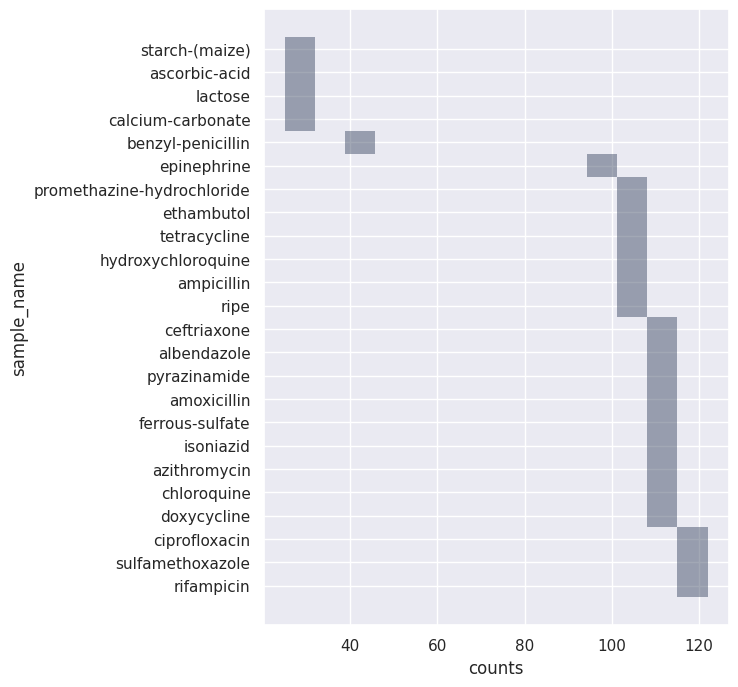

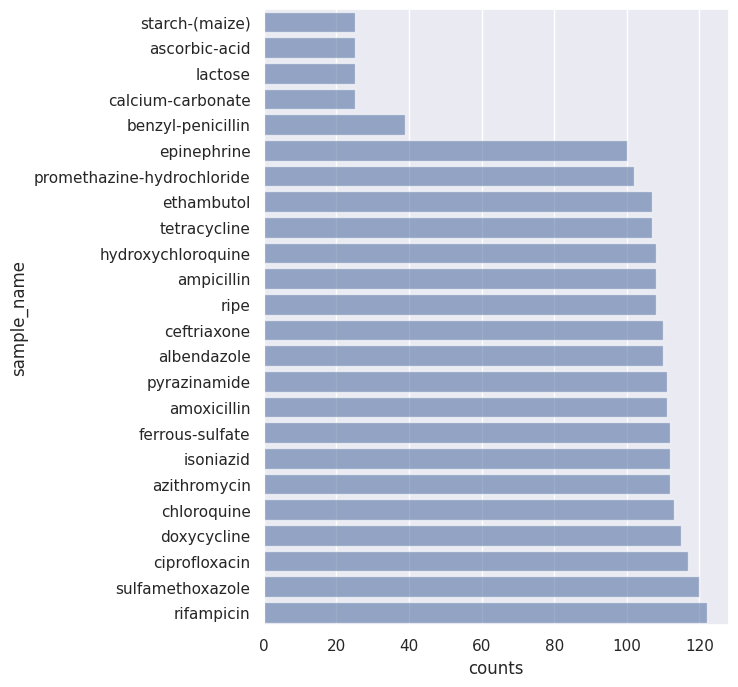

In [130]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(6, 8))
sns.histplot(data=samples_unique_grp.sort_values(by=['counts']), x="counts",  y="sample_name",  alpha=0.5, linewidths=.8)
plt.show()

fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(samples_unique_grp.sort_values(by=['counts']), x='counts', y="sample_name", orient="y", alpha=0.6)
plt.show()

In [131]:
samples_unique = data[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')

In [132]:
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df1

,sample_name,quantity,counts
0,sulfamethoxazole,50,38
1,ampicillin,100,37
2,chloroquine,100,32
3,albendazole,100,32
4,rifampicin,80,32
...,...,...,...
79,ampicillin,50,22
80,benzyl-penicillin,20,12
81,benzyl-penicillin,80,11
82,benzyl-penicillin,100,10


In [133]:
df2 = data[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
1,hydroxychloroquine,80,194
2,hydroxychloroquine,50,189
3,hydroxychloroquine,100,157
4,chloroquine,20,138
...,...,...,...
79,ampicillin,80,39
80,benzyl-penicillin,80,31
81,benzyl-penicillin,20,29
82,benzyl-penicillin,100,22


In [134]:
df1.loc[df1.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
33,hydroxychloroquine,80,27
34,hydroxychloroquine,100,27
40,hydroxychloroquine,20,27
47,hydroxychloroquine,50,27


In [135]:
df2.loc[df2.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
1,hydroxychloroquine,80,194
2,hydroxychloroquine,50,189
3,hydroxychloroquine,100,157


NOTE: *`df1`* gives counts by **unique sample_id** and *`df2`* gives counts considering  **duplicated sample_id** (the total of picutures) 

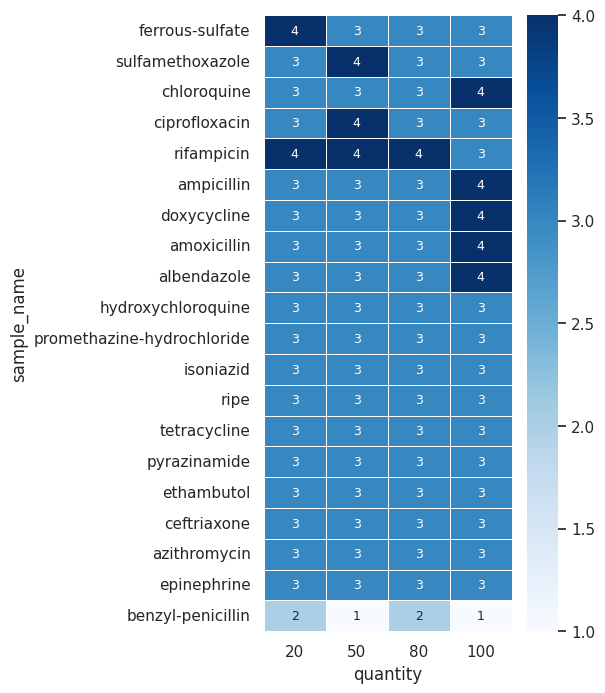

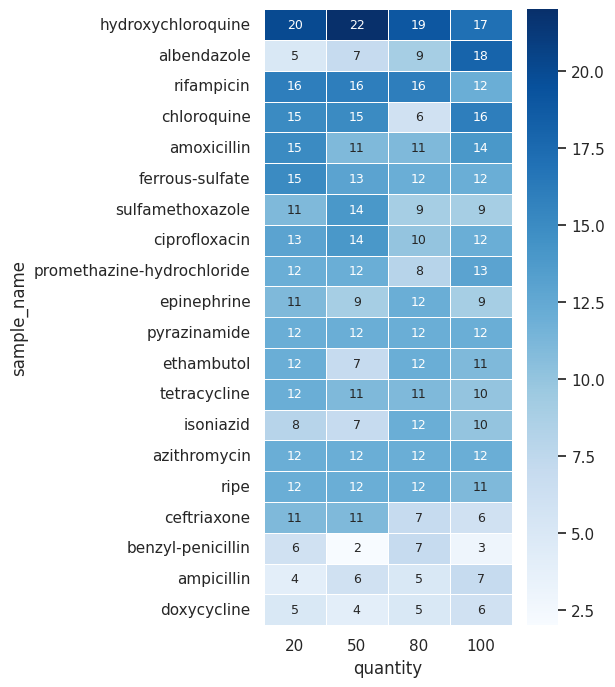

In [140]:
rows = "sample_name"
cols = "quantity"
values = "counts"
rows_order = unique_class_counter['sample_name'].to_list()

show_heatmap(df1, rows, cols, values, rows_order)
show_heatmap(df2, rows, cols, values, rows_order)

## Split the dataset in development and test sets


In [141]:
from sklearn.model_selection import GroupShuffleSplit

sample_names = ['amoxicillin', 'chloroquine', 'hydroxychloroquine',
       'promethazine-hydrochloride', 'ampicillin', 'albendazole',
       'ciprofloxacin','benzyl-penicillin', 'isoniazid', 'tetracycline',
       'ceftriaxone', 'sulfamethoxazole', 'doxycycline', 'epinephrine',
       'ethambutol', 'ferrous-sulfate', 'rifampicin', 'pyrazinamide',
       'azithromycin', 'ripe']
quantities = data['quantity'].unique()


# Initialize the splitter
random_state = 42
test_size = 0.1
splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)

# I'll split based on 'sample_id' to ensure images of the same card stay together
# Assuming 'group' here would represent the combined 'sample_name' and 'quantity' for stratification
all_train_idx = []
all_test_idx = []
for sample_name in sample_names:
    for quantity in quantities:
        #print(f"\n{sample_name}\t{quantity}")
        subset = data[(data['sample_name'] == sample_name) & (data['quantity'] == quantity)]
        
        # Perform the split
        for train_idx, test_idx in splitter.split(subset, groups=subset['sample_id']):
            train_subset = subset.iloc[train_idx]
            test_subset = subset.iloc[test_idx]

            # append these subsets to the overall training and testing set indexes
            all_train_idx += train_subset.index.tolist()
            all_test_idx += test_subset.index.tolist()
            #print(f"train {len(train_idx)} test {len(test_idx)}")
            
test_df = data.iloc[all_test_idx]
train_val_df = data.iloc[all_train_idx]

#### `test_df`

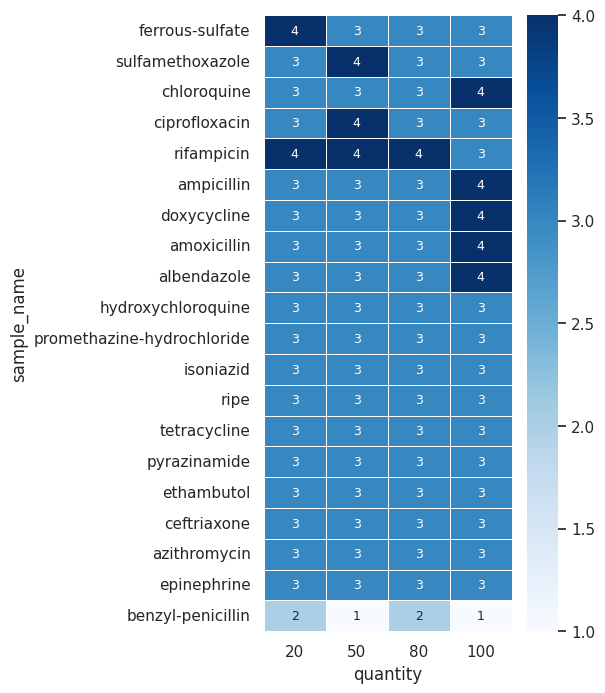

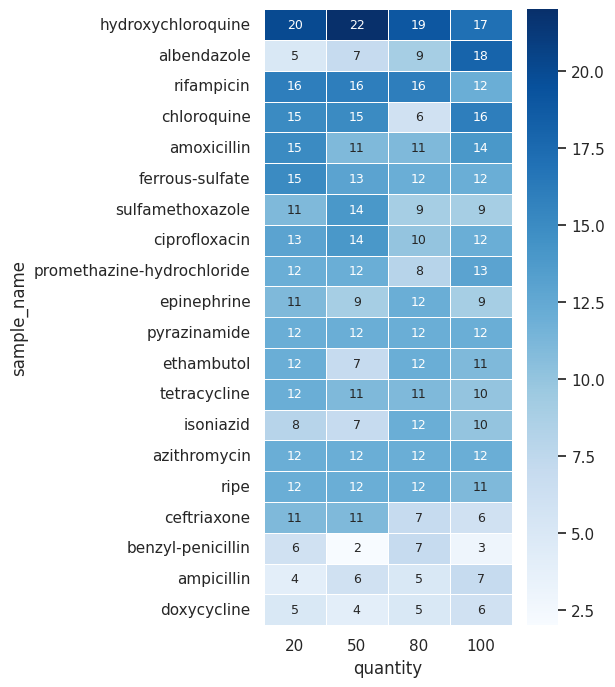

In [142]:
set_df = test_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
rows_order = unique_class_counter['sample_name'].to_list()

show_heatmap(df1, rows, cols, values, rows_order)
show_heatmap(df2, rows, cols, values, rows_order)

#### `train_val_df`

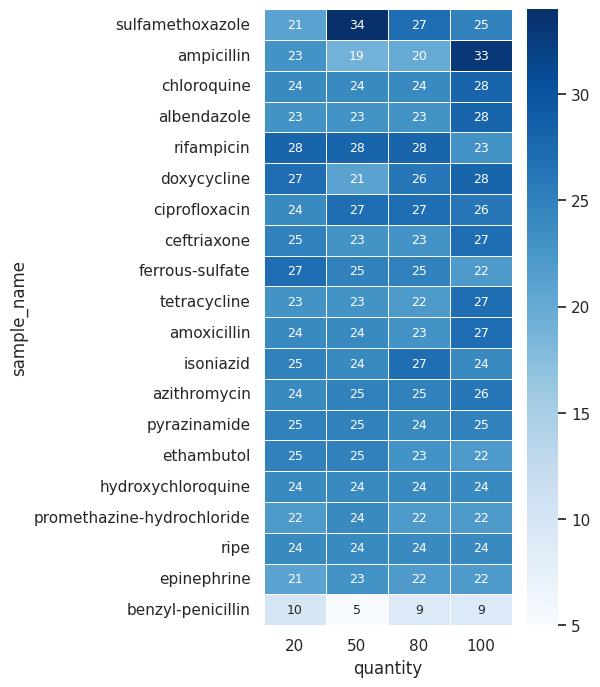

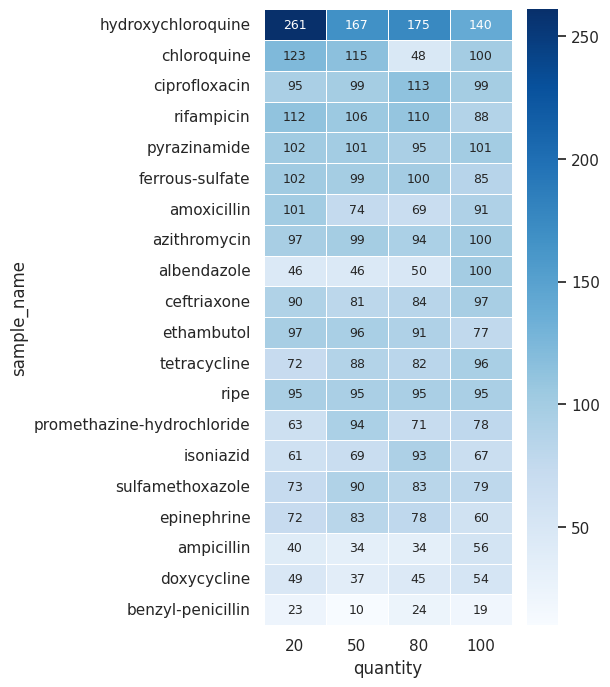

In [143]:
set_df = train_val_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
rows_order = unique_class_counter['sample_name'].to_list()

show_heatmap(df1, rows, cols, values, rows_order)
show_heatmap(df2, rows, cols, values, rows_order)

#### check if the sets don't have intersections in terms of sample_id

In [144]:
# Size of sets considering all images
print(f"# Size of sets considering all images")
print(f" - train_val: {len(train_val_df)}")
print(f" - test: {len(test_df)}")
print(f" - total: {len(data)}")
print()

# Size of sets considering unique sample_ids
print(f"# Size of sets considering unique sample_ids")
print(f" - train_val: {len(train_val_df.groupby(['sample_id']))}")
print(f" - test: {len(test_df.groupby(['sample_id']))}")
print(f" - total: {len(data.groupby(['sample_id']))}")
print()

# Size of sets considering all images
 - train_val: 6773
 - test: 871
 - total: 7888

# Size of sets considering unique sample_ids
 - train_val: 1899
 - test: 245
 - total: 2244



In [145]:
ids_test = test_df.loc[(test_df.sample_name == 'benzyl-penicillin') & (test_df.quantity == 20), 'sample_id']
ids_trainval = train_val_df.loc[(train_val_df.sample_name == 'benzyl-penicillin') & (train_val_df.quantity == 20), 'sample_id']

pd.Series(list(set(ids_trainval).intersection(set(ids_test))))

/tmp/108874.1.long/ipykernel_3846229/962289832.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(list(set(ids_trainval).intersection(set(ids_test))))


Series([], dtype: float64)

## Save metadata



- checking any left duplicates

In [146]:
_ = check_duplicates_by_hash(data)

There is no duplicates.


### Set Dataset GENRAL metadata

In [147]:
dataset_name = 'FHI2020_Stratified_Sampling'
dataset_description = """This dataset is based on data from Project FHI2020 and comprises images from PADs, each representing a specific API from a predefined list of 20 APIs and one of four possible quantities (20, 50, 80, 100). The dataset features multiple images of the same PAD, captured under varying illumination conditions and using different devices, each image uniquely identified by an image_id, while cards share a sample_id. To address the challenge posed by its unbalanced nature regarding API names and quantities, a stratified sampling approach was employed for data splitting. Specifically, the dataset was divided such that for each API, and within each quantity category of that API, 10% of the PADs(considering all their photographs) were allocated to the test set, ensuring a proportional representation across both developing and testing subsets. This method not only maintains the balance of API types and quantities but also ensures that all photographs of the same PAD are kept together, either in the developing or the test set, to prevent data leakage and promote model generalizability.There are no distractors included in this dataset."""
dev_size = 1 - test_size
random_state = 42
hash_type = 'hashlib_md5'


### Save metadata to the yaml file

In [148]:
import pandas as pd
import yaml

# Iterate through each row in the dataframe and add pad information to metadata
def add_pad_info_to_metadata(dataframe, metadata, dataset_name):
    for index, row in dataframe.iterrows():
        pad_info = {
            'id': row['id'],
            'sample_id': row['sample_id'],
            'sample_name': row['sample_name'],
            'quantity': row['quantity'],            
            'filename': create_filename(row),
            'image_hash': row[hash_type],
            'image_source': row['url']
        }
        metadata[dataset_name].append(pad_info)

metadata = {
    'name': dataset_name,
    'description': dataset_description,
    'creation':  get_iso8601_datetime(),
    'split': {  # Save information about the dataset splitting in development and test sets
        'dev_size': dev_size,        
        'random_seed': random_state
    },
    'hash_type': hash_type,
    'dev_set': [], # train_val_df
    'test_set': [] # test_df
}

# Create a path for that dataset
dataset_path = os.path.join( "../datasets/", dataset_name) 
os.makedirs(dataset_path, exist_ok=True)

# add metadata for each subset
add_pad_info_to_metadata(train_val_df, metadata, 'dev_set')
add_pad_info_to_metadata(test_df, metadata, 'test_set')

# Convert the metadata dictionary to YAML format
yaml_output = yaml.dump(metadata, sort_keys=False)

# Save the YAML data to a file
fpath = os.path.join(dataset_path, "metadata.yaml")
with open(fpath, 'w') as yaml_file:
    yaml_file.write(yaml_output)

print("Metadata file 'metadata.yaml' has been created.")


Metadata file 'metadata.yaml' has been created.



- [TODO] Savei nfo about the dataset and statistics with the plots
- [TODO] Clean this notebook to share